<a href="https://colab.research.google.com/github/BetulGull/BrainTumorClassification/blob/main/braintumorclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("GPU in use:", tf.config.list_physical_devices('GPU'))


GPU in use: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(data_dir, image_size=(150, 150)):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for idx, folder in enumerate(class_names):
        folder_path = os.path.join(data_dir, folder)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            try:
                img = Image.open(img_path).resize(image_size).convert('RGB')
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Skipped: {img_path} — Reason: {e}")

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(class_names))
    return images, labels, class_names

In [ ]:

train_dir = "/content/drive/MyDrive/ai/Training"
test_dir = "/content/drive/MyDrive/ai/Testing"

X_train, y_train, class_names = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Classes:", class_names)



Training samples: 5712
Testing samples: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# TRAINING
train_class_counts = dict(zip(class_names, np.sum(y_train, axis=0)))
print("🔹 Training samples per class:")
for cls, count in train_class_counts.items():
    print(f"{cls}: {int(count)}")

# TESTING
test_class_counts = dict(zip(class_names, np.sum(y_test, axis=0)))
print("\n🔹 Testing samples per class:")
for cls, count in test_class_counts.items():
    print(f"{cls}: {int(count)}")


🔹 Training samples per class:
glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457

🔹 Testing samples per class:
glioma: 300
meningioma: 306
notumor: 405
pituitary: 300


In [ ]:
from tensorflow.keras import layers, models, callbacks

def build_cnn_model(input_shape=(64, 64, 3), num_classes=4):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # ← Overfitting protection

    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # ← Heavier Dropout here
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()
    return model

In [ ]:

model = build_cnn_model(input_shape=(150, 150, 3), num_classes=len(class_names))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ⏹️ Optional: Stop training if val_loss gets worse
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,764 (18.42 MB)

 Trainable params: 4,829,316 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])



Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.5860 - loss: 3.6702 - val_accuracy: 0.2288 - val_loss: 31.2994
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.6635 - loss: 0.8085 - val_accuracy: 0.4554 - val_loss: 3.6779
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7028 - loss: 0.7037 - val_accuracy: 0.5789 - val_loss: 1.8276
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7244 - loss: 0.6713 - val_accuracy: 0.7330 - val_loss: 0.6091
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7493 - loss: 0.6287 - val_accuracy: 0.7971 - val_loss: 0.4818


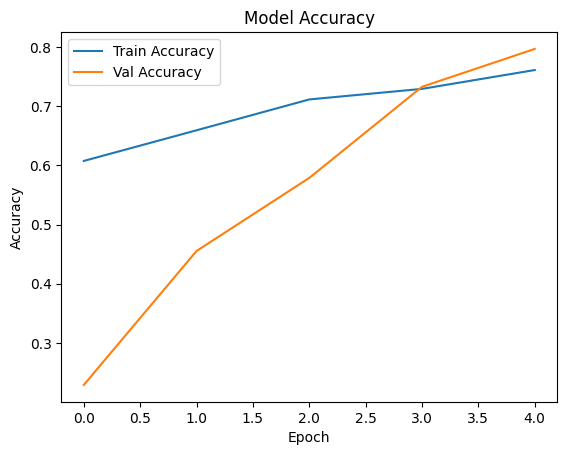

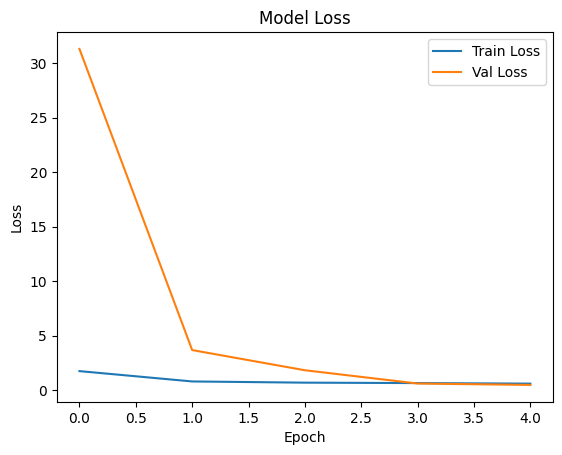

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7173 - loss: 0.5567
Test accuracy: 0.7971, Test loss: 0.4818


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


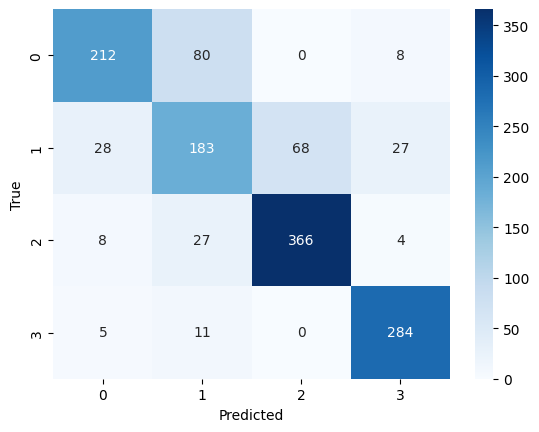

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       300
           1       0.61      0.60      0.60       306
           2       0.84      0.90      0.87       405
           3       0.88      0.95      0.91       300

    accuracy                           0.80      1311
   macro avg       0.79      0.79      0.79      1311
weighted avg       0.80      0.80      0.79      1311



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Also print classification report
print(classification_report(y_true, y_pred_classes))


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Precision: 0.7954
Recall:    0.7971
F1 Score:  0.7943


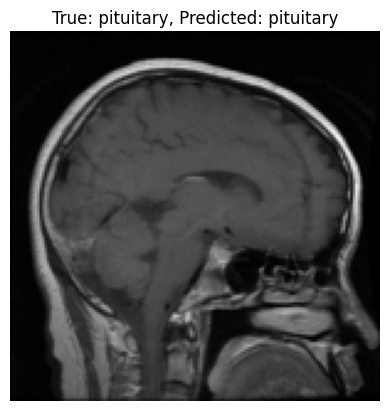

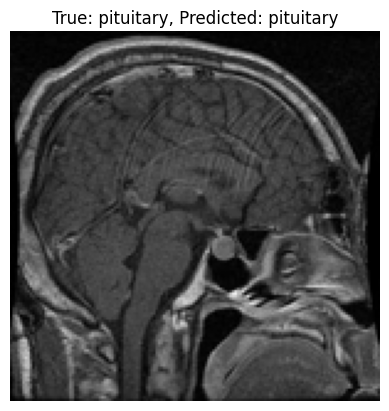

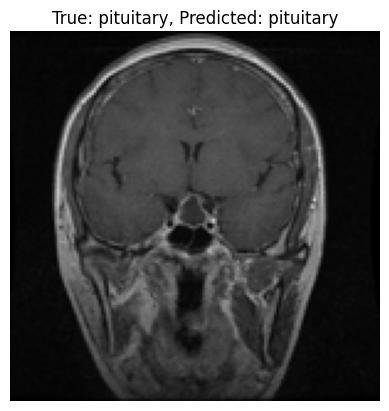

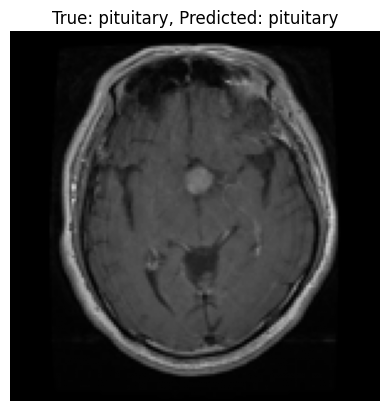

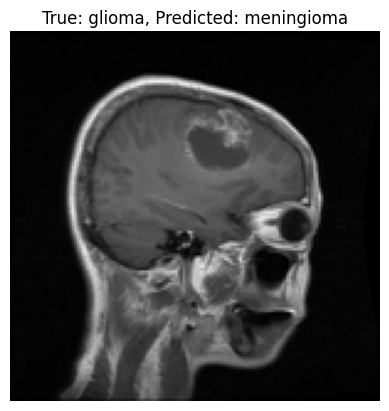

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define class names in the same order as they appear in your labels
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Pick 3 random test images
indices = random.sample(range(len(X_test)), 5)

for i in indices:
    img = X_test[i]
    true_label = np.argmax(y_test[i])

    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = np.argmax(pred)

    # Plot
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

def build_transfer_learning_model(input_shape=(150, 150, 3), num_classes=4):
    # Load pre-trained VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.summary()
    return model, base_model

In [ ]:
# Create transfer learning model
transfer_model, base_model = build_transfer_learning_model(input_shape=(150, 150, 3),
                                                          num_classes=len(class_names))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,124 (64.14 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


In [ ]:
# Train the model with frozen base layers
print("Starting initial training with frozen base layers...")
transfer_history_initial = transfer_model.fit(X_train, y_train,
                                             epochs=5,  # Fewer epochs for initial training
                                             batch_size=32,
                                             validation_data=(X_test, y_test),
                                             callbacks=[early_stop])


Starting initial training with frozen base layers...
Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - accuracy: 0.6663 - loss: 1.0092 - val_accuracy: 0.8360 - val_loss: 0.4320
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - accuracy: 0.8683 - loss: 0.3721 - val_accuracy: 0.8658 - val_loss: 0.3405
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.8892 - loss: 0.2914 - val_accuracy: 0.8757 - val_loss: 0.2865
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.9104 - loss: 0.2606 - val_accuracy: 0.8909 - val_loss: 0.2619
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.9143 - loss: 0.2262 - val_accuracy: 0.9062 - val_loss: 0.2370


In [ ]:
# Fine-tuning step: Unfreeze some layers of the base model
print("\n==== FINE-TUNING TRANSFER LEARNING MODEL ====")
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True


==== FINE-TUNING TRANSFER LEARNING MODEL ====


In [ ]:
# Recompile with lower learning rate
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Continue training with fine-tuning
print("Starting fine-tuning...")
transfer_history_fine_tune = transfer_model.fit(X_train, y_train,
                                               epochs=3,  # Just a few epochs for fine-tuning
                                               batch_size=32,
                                               validation_data=(X_test, y_test),
                                               callbacks=[early_stop])


Starting fine-tuning...
Epoch 1/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.9266 - loss: 0.1939 - val_accuracy: 0.9382 - val_loss: 0.1618
Epoch 2/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.9509 - loss: 0.1357 - val_accuracy: 0.9458 - val_loss: 0.1320
Epoch 3/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - accuracy: 0.9610 - loss: 0.1086 - val_accuracy: 0.9626 - val_loss: 0.1068


In [ ]:
# Save the transfer learning model
transfer_model.save('/content/drive/MyDrive/ai/transfer_learning_model.h5')
print("Transfer Learning model saved!")

Transfer Learning model saved!


In [ ]:
# Combine the training histories
def plot_combined_history(initial_history, fine_tune_history):
    acc = initial_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy']
    loss = initial_history.history['loss']
    val_loss = initial_history.history['val_loss']

    # Add fine-tuning history
    acc += fine_tune_history.history['accuracy']
    val_acc += fine_tune_history.history['val_accuracy']
    loss += fine_tune_history.history['loss']
    val_loss += fine_tune_history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.axvline(x=len(initial_history.history['accuracy']), color='r', linestyle='--')
    plt.text(len(initial_history.history['accuracy']), 0.5, 'Start Fine Tuning', rotation=90)
    plt.title('Transfer Learning Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.axvline(x=len(initial_history.history['loss']), color='r', linestyle='--')
    plt.text(len(initial_history.history['loss']), 0.5, 'Start Fine Tuning', rotation=90)
    plt.title('Transfer Learning Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

<ipython-input-25-cf07e0f84a22>:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


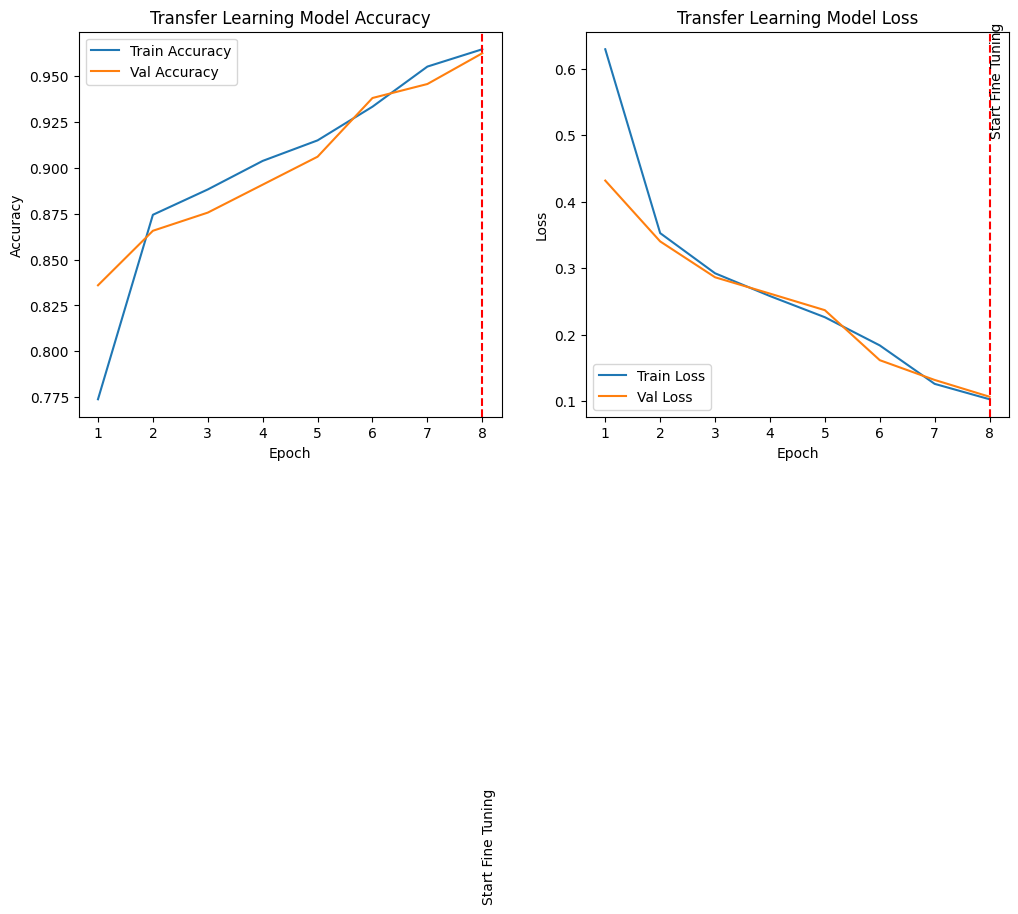

In [ ]:
# Visualize combined training history
plot_combined_history(transfer_history_initial, transfer_history_fine_tune)

In [ ]:
# Evaluate the transfer learning model
transfer_test_loss, transfer_test_acc = transfer_model.evaluate(X_test, y_test)
print(f"Transfer Learning - Test accuracy: {transfer_test_acc:.4f}, Test loss: {transfer_test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9348 - loss: 0.1864
Transfer Learning - Test accuracy: 0.9626, Test loss: 0.1068


In [ ]:
# Calculate performance metrics for transfer learning model
transfer_y_pred = transfer_model.predict(X_test)
transfer_y_pred_classes = np.argmax(transfer_y_pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step


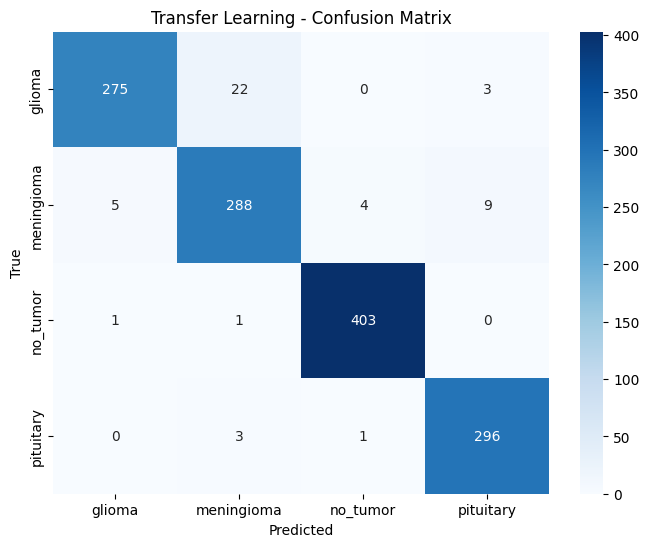

In [ ]:
# Create confusion matrix for transfer learning model
transfer_cm = confusion_matrix(y_true, transfer_y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(transfer_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Transfer Learning - Confusion Matrix")
plt.show()


In [ ]:
# Print classification report for transfer learning model
print("Transfer Learning - Classification Report:")
print(classification_report(y_true, transfer_y_pred_classes, target_names=class_names))


Transfer Learning - Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.92      0.94      0.93       306
    no_tumor       0.99      1.00      0.99       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [ ]:
# Calculate precision, recall, and F1 score for transfer learning model
transfer_precision = precision_score(y_true, transfer_y_pred_classes, average='weighted')
transfer_recall = recall_score(y_true, transfer_y_pred_classes, average='weighted')
transfer_f1 = f1_score(y_true, transfer_y_pred_classes, average='weighted')

print(f"Transfer Learning - Precision: {transfer_precision:.4f}")
print(f"Transfer Learning - Recall:    {transfer_recall:.4f}")
print(f"Transfer Learning - F1 Score:  {transfer_f1:.4f}")

Transfer Learning - Precision: 0.9631
Transfer Learning - Recall:    0.9626
Transfer Learning - F1 Score:  0.9625


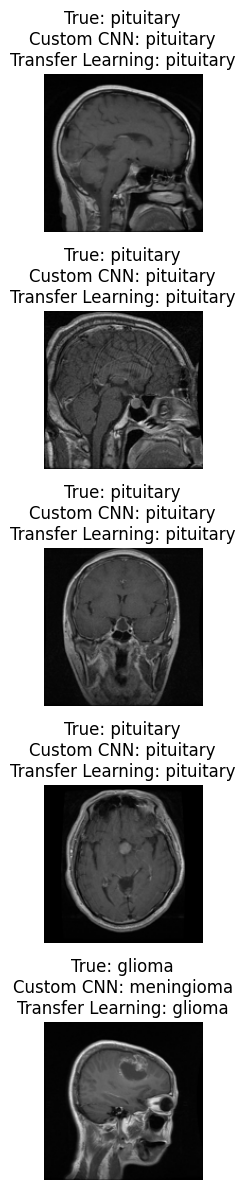

In [ ]:
plt.figure(figsize=(15, 12))  # Taller figure for 5 rows
for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = np.argmax(y_test[idx])

    # Predict with custom CNN
    cnn_pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    cnn_pred_label = np.argmax(cnn_pred)

    # Predict with transfer learning model
    transfer_pred = transfer_model.predict(np.expand_dims(img, axis=0), verbose=0)
    transfer_pred_label = np.argmax(transfer_pred)

    # Plot in a 5x1 grid
    plt.subplot(5, 1, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}\nCustom CNN: {class_names[cnn_pred_label]}\nTransfer Learning: {class_names[transfer_pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Model Comparison Summary
print("\n===== MODEL COMPARISON =====")
print(f"{'Metric':<20} {'Custom CNN':<15} {'Transfer Learning':<15}")
print("-" * 50)
print(f"{'Test Accuracy':<20} {test_acc:.4f}{'':<10} {transfer_test_acc:.4f}")
print(f"{'Precision':<20} {precision:.4f}{'':<10} {transfer_precision:.4f}")
print(f"{'Recall':<20} {recall:.4f}{'':<10} {transfer_recall:.4f}")
print(f"{'F1 Score':<20} {f1:.4f}{'':<10} {transfer_f1:.4f}")
print("-" * 50)


===== MODEL COMPARISON =====
Metric               Custom CNN      Transfer Learning
--------------------------------------------------
Test Accuracy        0.7971           0.9626
Precision            0.7954           0.9631
Recall               0.7971           0.9626
F1 Score             0.7943           0.9625
--------------------------------------------------


In [ ]:
# Compare model architecture
print("\n===== MODEL ARCHITECTURE COMPARISON =====")
print("Custom CNN Parameters:", model.count_params())
print("Transfer Learning Parameters:", transfer_model.count_params())


===== MODEL ARCHITECTURE COMPARISON =====
Custom CNN Parameters: 4829764
Transfer Learning Parameters: 16813124


In [ ]:
# Save the comparison results
with open('/content/drive/MyDrive/ai/model_comparison.txt', 'w') as f:
    f.write("===== MODEL COMPARISON =====\n")
    f.write(f"{'Metric':<20} {'Custom CNN':<15} {'Transfer Learning':<15}\n")
    f.write("-" * 50 + "\n")
    f.write(f"{'Test Accuracy':<20} {test_acc:.4f}{'':<10} {transfer_test_acc:.4f}\n")
    f.write(f"{'Precision':<20} {precision:.4f}{'':<10} {transfer_precision:.4f}\n")
    f.write(f"{'Recall':<20} {recall:.4f}{'':<10} {transfer_recall:.4f}\n")
    f.write(f"{'F1 Score':<20} {f1:.4f}{'':<10} {transfer_f1:.4f}\n")
    f.write("-" * 50 + "\n\n")
    f.write("===== MODEL ARCHITECTURE COMPARISON =====\n")
    f.write(f"Custom CNN Parameters: {model.count_params():,}\n")
    f.write(f"Transfer Learning Parameters: {transfer_model.count_params():,}\n")

print("Comparison results saved to '/content/drive/MyDrive/ai/model_comparison.txt'")

Comparison results saved to '/content/drive/MyDrive/ai/model_comparison.txt'
